In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm  # For progress bar

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score,
    recall_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz
from skfuzzy import control as ctrl

import chardet

In [18]:
# load the data
with open('data/spam.csv', 'rb') as file:
    result = chardet.detect(file.read())
encoding = result['encoding']
df = pd.read_csv('data/spam.csv', encoding=encoding, names=['isHam', 'text', 'v3', 'v4', 'v5'], header=0)
df = df[['isHam', 'text']]
df['isHam'] = df['isHam'].apply(lambda x: 0 if x == 'spam' else 1)
df.head()

,isHam,text
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
# Shuffle the dataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Download stopwords
nltk.download("stopwords")

# Endlish stopwords
stop_words = stopwords.words('english')
stop_words[:10]

# Remove stopwords
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and token not in stop_words:
            result.append(token)
            
    return result

# Apply the function to the dataframe
df['clean'] = df['text'].apply(preprocess)

# Join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
df = df.drop(columns=['text', 'clean'])
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\frank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,isHam,clean_joined
0,1,funny fact teaches volcanoes erupt tsunamis ar...
1,1,sent scores sophas secondary application schoo...
2,0,know know fancies pobox ls hb
3,1,promise getting soon text morning let know ok
4,0,congratulations ur awarded cd gift vouchers fr...


In [20]:
# Replace the tokenizer instantiation with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Convert the dataset to features as the input for Bert model
def convert_examples_to_features(texts, tokenizer, max_length=512):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',           
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True,
            return_tensors='pt'              # Output as PyTorch tensors directly
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Concatenate into big tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Apply on the test data
x_test = df['clean_joined']
y_test = torch.tensor(df['isHam'].values)  # Labels as PyTorch tensor

input_ids, attention_mask = convert_examples_to_features(x_test, tokenizer, max_length=512)

In [21]:
# Implement BERT classifier in PyTorch with frozen encoder

class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        
        # Load pre-trained BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False
        
        # Classifier layers
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # shape: (batch_size, seq_length, hidden_size)

        # Global average pooling over the sequence length
        x = last_hidden_state.permute(0, 2, 1)  # (batch_size, hidden_size, seq_length)
        x = self.pool(x).squeeze(-1)             # (batch_size, hidden_size)

        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [22]:
# Load the model
model = BertClassifier()
model.load_state_dict(torch.load("bert_pretrain_classifier.pt"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Prepare column
df['real_prob'] = 0.0

# Loop through rows and compute probability
for i in tqdm(range(len(df))):
    text = df.loc[i, 'clean_joined']

    # Tokenize with truncation for BERT input
    encoded = tokenizer(
        text,
        max_length=512,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask)
        prob_real = output.squeeze().item()  # sigmoid output ∈ [0, 1]

    df.at[i, 'real_prob'] = prob_real

100%|██████████| 5572/5572 [00:31<00:00, 175.28it/s]


In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("GroNLP/mdebertav3-subjectivity-english")
model = AutoModelForSequenceClassification.from_pretrained("GroNLP/mdebertav3-subjectivity-english")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Add columns for subjectivity scores
df['subj_score'] = 0.0

# Compute scores for all sentences
for i in tqdm(range(len(df))):
    text = df.loc[i, 'clean_joined']
    
    # Tokenize and move to device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[0]
        df.at[i, 'subj_score'] = probs[1].item()

100%|██████████| 8979/8979 [01:48<00:00, 82.51it/s]


In [14]:
# Count tokens and whether they will be truncated
df['token_count'] = df['clean_joined'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))
df['was_truncated'] = df['token_count'] > 512

In [19]:
# Define breakpoints for fuzzy bins
a, b, c = 0.25, 0.50, 0.75  # For both subj_score and real_prob

# Define the fuzzy variables
subjectivity = ctrl.Antecedent(np.linspace(0, 1, 1000), 'subjectivity')
realness = ctrl.Antecedent(np.linspace(0, 1, 1000), 'realness_prob')
trust = ctrl.Consequent(np.linspace(0, 1, 1000), 'trust_score')

# Parameterized cutoffs
a, b, c = 0.25, 0.50, 0.75  # Change these as needed

# Membership functions for subjectivity
subjectivity['very_low'] = fuzz.trimf(subjectivity.universe, [0, 0, a])
subjectivity['low'] = fuzz.trimf(subjectivity.universe, [0, a, b])
subjectivity['medium'] = fuzz.trimf(subjectivity.universe, [a, b, c])
subjectivity['high'] = fuzz.trimf(subjectivity.universe, [b, 1.0, 1.0])

# Membership functions for realness probability
realness['very_low'] = fuzz.trimf(realness.universe, [0, 0, a])
realness['low'] = fuzz.trimf(realness.universe, [0, a, b])
realness['medium'] = fuzz.trimf(realness.universe, [a, b, c])
realness['high'] = fuzz.trimf(realness.universe, [b, 1.0, 1.0])

# Output membership (can be adjusted)
trust['low'] = fuzz.trimf(trust.universe, [0, 0, 0.5])
trust['medium'] = fuzz.trimf(trust.universe, [0.2, 0.5, 0.8])
trust['high'] = fuzz.trimf(trust.universe, [0.5, 1.0, 1.0])

# Fuzzy rule base
rules = [
    ctrl.Rule(subjectivity['very_low'] & realness['very_low'], trust['medium']),
    ctrl.Rule(subjectivity['very_low'] & realness['low'],      trust['medium']),
    ctrl.Rule(subjectivity['very_low'] & realness['medium'],   trust['high']),     # still strong 
    ctrl.Rule(subjectivity['very_low'] & realness['high'],     trust['high']),     # best zone 

    ctrl.Rule(subjectivity['low'] & realness['very_low'], trust['low']),
    ctrl.Rule(subjectivity['low'] & realness['low'],      trust['medium']),
    ctrl.Rule(subjectivity['low'] & realness['medium'],   trust['medium']),
    ctrl.Rule(subjectivity['low'] & realness['high'],     trust['low']),          # risky zone 

    ctrl.Rule(subjectivity['medium'] & realness['very_low'], trust['low']),
    ctrl.Rule(subjectivity['medium'] & realness['low'],      trust['low']),
    ctrl.Rule(subjectivity['medium'] & realness['medium'],   trust['medium']),
    ctrl.Rule(subjectivity['medium'] & realness['high'],     trust['low']),       # overconfident zone 

    ctrl.Rule(subjectivity['high'] & realness['very_low'], trust['low']),
    ctrl.Rule(subjectivity['high'] & realness['low'],      trust['low']),        # unsure zone 
    ctrl.Rule(subjectivity['high'] & realness['medium'],   trust['low']),
    ctrl.Rule(subjectivity['high'] & realness['high'],     trust['low']),
]

# Build control system
trust_ctrl = ctrl.ControlSystem(rules)
simulator = ctrl.ControlSystemSimulation(trust_ctrl)

In [21]:
# Apply to DataFrame
fuzzy_scores = []
for i in tqdm(range(len(df))):
    subj_val = df.loc[i, 'subj_score']
    real_val = df.loc[i, 'real_prob']
    
    simulator.input['subjectivity'] = subj_val
    simulator.input['realness_prob'] = real_val
    try:
        simulator.compute()
        fuzzy_scores.append(simulator.output['trust_score'])
    except:
        fuzzy_scores.append(np.nan)  # handle edge cases if any

df['fuzzy_trust_score'] = fuzzy_scores

100%|██████████| 8979/8979 [00:31<00:00, 284.91it/s]


In [22]:
# 1. Prepare input features and target
features = ['real_prob', 'fuzzy_trust_score', 'subj_score', 'token_count', 'was_truncated']
X = df[features].values.astype('float32')
y = df['isReal'].values.astype('float32')

# 2. Normalize 'token_count' for stable training
scaler = StandardScaler()
X[:, 3:4] = scaler.fit_transform(X[:, 3:4])  # only token_count column

# 3. Convert to PyTorch tensors
X_test_tensor = torch.tensor(X, dtype=torch.float32)

# 4. Define deeper meta-model
meta_model = nn.Sequential(
    nn.Linear(X.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)

# 5. Load saved weights
meta_model.load_state_dict(torch.load("final_classifier.pt"))
meta_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
meta_model.to(device)

# 6. Run inference
with torch.no_grad():
    logits = meta_model(X_test_tensor.to(device))
    probs = torch.sigmoid(logits).cpu().numpy().flatten()
    preds = (probs > 0.5).astype(int)

Accuracy:        0.9534
Precision:       0.9442
Recall:          0.9591
F1 Score:        0.9516
ROC AUC Score:   0.9891


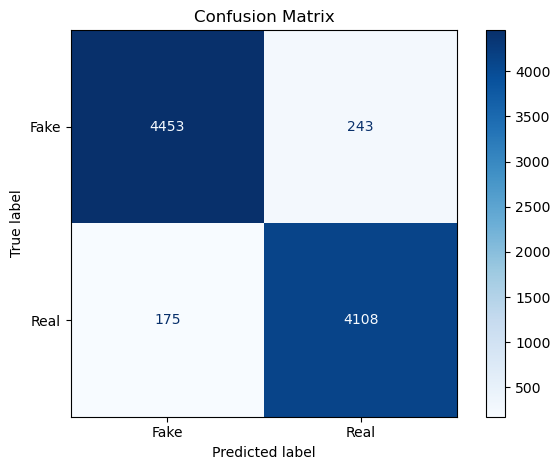

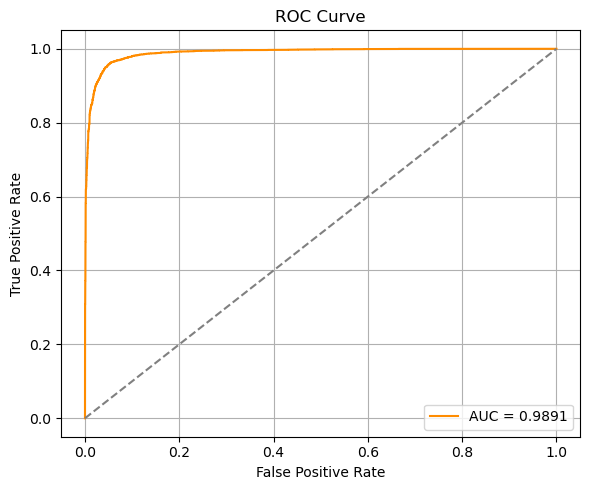

In [27]:
# Evaluate

# Ground truth
y_true = df['isReal'].values

# Metrics
acc = accuracy_score(y_true, preds)
f1 = f1_score(y_true, preds)
precision = precision_score(y_true, preds)
recall = recall_score(y_true, preds)
roc_auc = roc_auc_score(y_true, probs)

print(f"Accuracy:        {acc:.4f}")
print(f"Precision:       {precision:.4f}")
print(f"Recall:          {recall:.4f}")
print(f"F1 Score:        {f1:.4f}")
print(f"ROC AUC Score:   {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_true, probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()